In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
#test scipy.integrate

def exponential_decay(t, y):
    return -0.5 * y

sol = solve_ivp(exponential_decay, [0, 10], [2, 4, 8], t_eval=[0, 1, 2, 4, 10])
print(sol.t)
print(sol.y)

[ 0  1  2  4 10]
[[2.         1.21305369 0.73534021 0.27069123 0.01350781]
 [4.         2.42610739 1.47068043 0.54138247 0.02701561]
 [8.         4.85221478 2.94136085 1.08276494 0.05403123]]


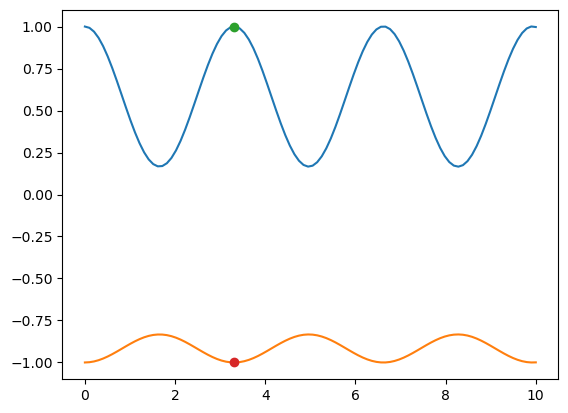

In [3]:
# define elastic force here

def elastic_force(y, k, l, m):
    
    r1       = y[0:3] - y[6:9]
    distance = np.sqrt(r1.dot(r1))
    F1       = -k*r1*(1 - l/distance)
    F2       = -F1
    
    return F1, F2

def f(t, y, k, l, m):
    
    F1, F2 = elastic_force(y, k, l, m)
    
    a1 = F1/m[0]
    a2 = F2/m[1]
    
    y_der       = y.copy()
    y_der[0:3]  = y[3:6]
    y_der[6:9]  = y[9:12]
    y_der[3:6]  = a1
    y_der[9:12] = a2
    
    return y_der

# unit test

t_span = np.array([0, 10])
y0     = np.array([1,0,0,0,0,0,-1,0,0,0,0,0])
N      = 100
k      = 3
l      = 1.5
m      = np.array([1,5])
sol_elastic = solve_ivp(f, t_span, y0,
                t_eval=np.linspace(t_span[0], t_span[1], N), args = (k,l,m))
'''
print(sol.t)
print(sol.y)
'''

plt.plot(sol_elastic.t, sol_elastic.y[0,:])
plt.plot(sol_elastic.t, sol_elastic.y[6,:])

reduced_mass = m[0]*m[1]/(m[0]+m[1])
w            = np.sqrt(k/reduced_mass)
period       = 2*np.pi/w

plt.plot(period, sol_elastic.y[0,0], 'o')
plt.plot(period, sol_elastic.y[6,0], 'o');

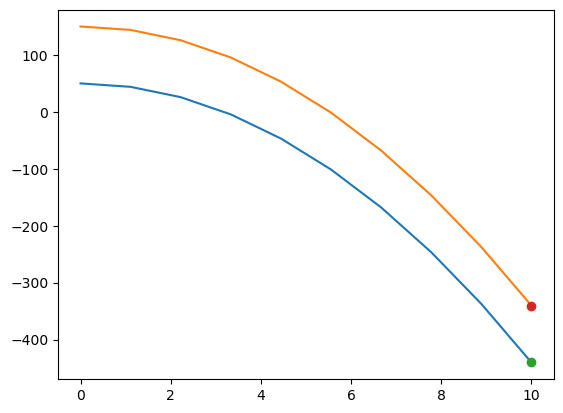

In [4]:
# define gravity here

def gravity(m, g=np.array([0,-9.80665,0])):
    
    F1 = m[0]*g
    F2 = m[1]*g
    
    return F1, F2

def f(t, y, m):
    
    F1, F2 = gravity(m)
    
    a1 = F1/m[0]
    a2 = F2/m[1]
    
    y_der       = y.copy()
    y_der[0:3]  = y[3:6]
    y_der[6:9]  = y[9:12]
    y_der[3:6]  = a1
    y_der[9:12] = a2
    
    return y_der

# unit test

t_span = np.array([0, 10])
y0     = np.array([1,50,0,0,0,0,-1,150,0,0,0,0])
N      = 10
m      = np.array([1,5])
sol_gravity = solve_ivp(f, t_span, y0,
                t_eval=np.linspace(t_span[0], t_span[1], N), args = (m,))
'''
print(sol.t)
print(sol.y)
'''

plt.plot(sol_gravity.t, sol_gravity.y[1,:])
plt.plot(sol_gravity.t, sol_gravity.y[7,:])
plt.plot(t_span[1], sol_gravity.y[1,0]-0.5*9.80665*t_span[1]**2, 'o')
plt.plot(t_span[1], sol_gravity.y[7,0]-0.5*9.80665*t_span[1]**2, 'o');

[[  50.           43.94651235   25.78604938   -4.48138889  -46.85580247
  -101.33719136 -167.92555556 -246.62089506 -337.42320988 -440.3325    ]
 [ 150.          143.94651235  125.78604938   95.51861111   53.14419753
    -1.33719136  -67.92555556 -146.62089506 -237.42320988 -340.3325    ]]
[[  0.         -10.89627778 -21.79255556 -32.68883333 -43.58511111
  -54.48138889 -65.37766667 -76.27394444 -87.17022222 -98.0665    ]
 [  0.         -10.89627778 -21.79255556 -32.68883333 -43.58511111
  -54.48138889 -65.37766667 -76.27394444 -87.17022222 -98.0665    ]]
-4.481388888888915


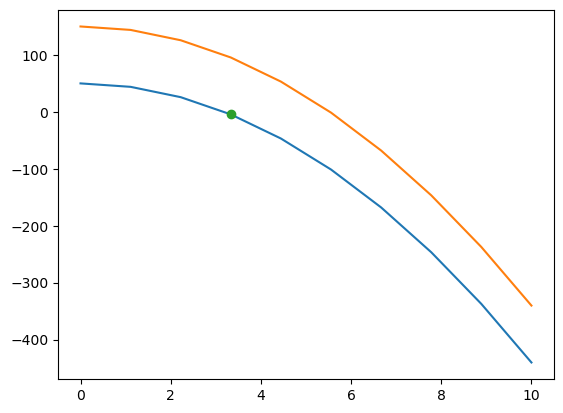

In [5]:
# define how to judge collision here

def collision_judge(sol):
    
    y = sol.y
    
    pos_y = y[1::6]
    vel_y = y[4::6]
    print(pos_y)
    print(vel_y)
    
    judge_pos  = pos_y <= 0
    judge_vel  = vel_y <= 0
    judge_both = judge_pos&judge_vel
    
    particle_number = []
    time_index      = []
    
    if any(judge_both.flatten()):
        collision_where = np.where(judge_both==True)
        collision_where = np.array(collision_where)
        collision_time_index = np.where(collision_where[1] == np.min(collision_where[1]))
        
        for index in collision_time_index[0]:
            particle_number.append(collision_where[0, index])
            time_index.append(collision_where[1, index])
        
    else:
        pass
    return particle_number, time_index

# unit test (using the sol of the previous unit test for gravity)

particle_number, time_index = collision_judge(sol_gravity)
plt.plot(sol_gravity.t, sol_gravity.y[1,:])
plt.plot(sol_gravity.t, sol_gravity.y[7,:])
for i, (number, index) in enumerate(zip(particle_number, time_index)):
    plt.plot(sol_gravity.t[index], sol_gravity.y[number*6+1,index],'o')
    print(sol_gravity.y[number*6+1,index])

In [6]:
def collision(sol):
    
    y = sol.y
    
    pos_y = y[1::6, 0]
    vel_y = y[4::6, 0]
    
    judge_pos  = pos_y <= 0
    judge_vel  = vel_y <= 0
    judge_both = judge_pos&judge_vel
    
    particle_number = []
    
    for i, judge in enumerate(judge_both):
        
        if judge:
            particle_number.append(i)
            print(judge_both)
        else:
            
            pass
        
    return particle_number

[ True  True]
[ True  True]
[0, 1]
-1.256485307621666
-14.858560606060596
[ True  True]
[ True  True]
[0, 1]
-1.256485307621661
-14.858560606060594
[ True  True]
[ True  True]
[0, 1]
-1.2564853076216604
-14.8585606060606


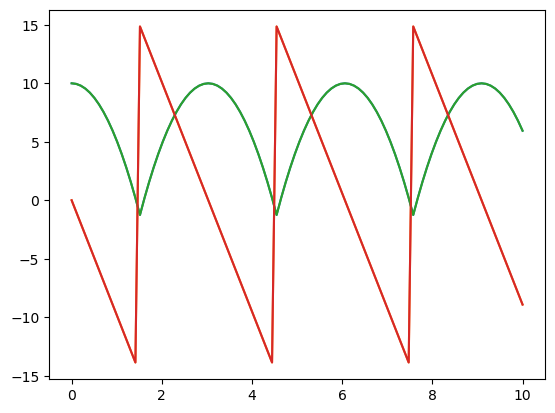

In [13]:
# define main here

def main(f, t_span, y0, k, l, m, N=100):
    
    t_eval = np.linspace(t_span[0], t_span[1], N)
    
    sol_final = np.zeros((len(y0),N))
    
    for i, t in enumerate(t_eval):
        
        if i == 0:
            
            sol_final[:, i] = y0
            
        else:
            
            sol = solve_ivp(f, (t_eval[i-1], t), sol_final[:, i-1], t_eval=(t,), args = (k,l,m))
            particle_number = collision(sol)
            
            if any(particle_number):
                print(particle_number)
                print(sol.y[1, 0])
                print(sol.y[4, 0])
                for number in particle_number:
                    #sol.y[6*number+1, 0] = 0
                    sol.y[6*number+4, 0] = -sol.y[6*number+4, 0]
                    
            else:
                pass
            
            sol_final[:, i] = sol.y[:, 0]
            
    return t_eval, sol_final

def f(t, y, k, l, m):
    
    F1_elastic, F2_elastic = elastic_force(y, k, l, m)
    F1_gravity, F2_gravity = gravity(m)
    
    F1 = F1_elastic + F1_gravity
    F2 = F2_elastic + F2_gravity
    a1 = F1/m[0]
    a2 = F2/m[1]
    
    y_der       = y.copy()
    y_der[0:3]  = y[3:6]
    y_der[6:9]  = y[9:12]
    y_der[3:6]  = a1
    y_der[9:12] = a2
    
    return y_der

y0 = np.array([1,10,0,0,0,0,-1,10,0,0,0,0])
k  = 3
l  = 1.5
m  = np.array([1,1])
    
N      = 100
t_span = np.array([0, 10])

t_eval, sol_final = main(f, t_span, y0, k, l, m, N)

plt.plot(t_eval, sol_final[1]);
plt.plot(t_eval, sol_final[4]);
plt.plot(t_eval, sol_final[7]);
plt.plot(t_eval, sol_final[10]);